In [1]:
!pip install lifelines==0.27.7

In [3]:
!pip install toad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 8.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from sklearn.model_selection import train_test_split, GridSearchCV
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn import metrics
import time
import math
import toad
import itertools
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import pairwise_logrank_test
from sklearn import preprocessing
from lifelines.calibration import survival_probability_calibration
from sklearn.metrics import brier_score_loss
from lifelines.utils import median_survival_times, qth_survival_times

plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")

In [5]:
raw_data = pd.read_csv('Customer-Churn.csv')
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df = raw_data.copy()
# （This model does not allow for non-positive durations）
df = df[df['tenure']>0]
#
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
# fillna
df['TotalCharges'].fillna(0, inplace=True)
# category
df['SeniorCitizen'] = df['SeniorCitizen'].astype("str")
# 0-1
df['Churn'] = df['Churn'].map({'No':0,'Yes':1})

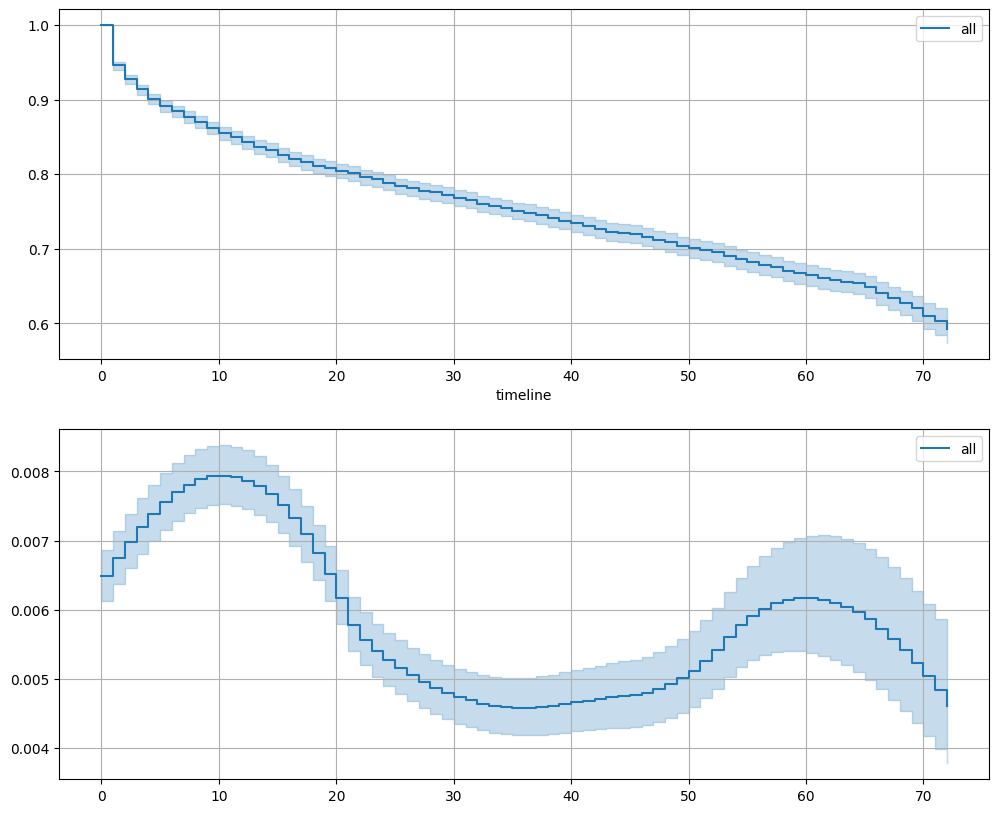

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

kmf = KaplanMeierFitter()
kmf.fit(df.tenure,  #lifetime
        event_observed=df.Churn  # end of event

        )
kmf.plot_survival_function(ax=ax[0], label='all')
ax[0].grid()
# overall change
naf = NelsonAalenFitter()
naf.fit(df.tenure, event_observed=df.Churn)
naf.plot_hazard(ax=ax[1], bandwidth=20, label='all')
ax[1].grid()
plt.show()

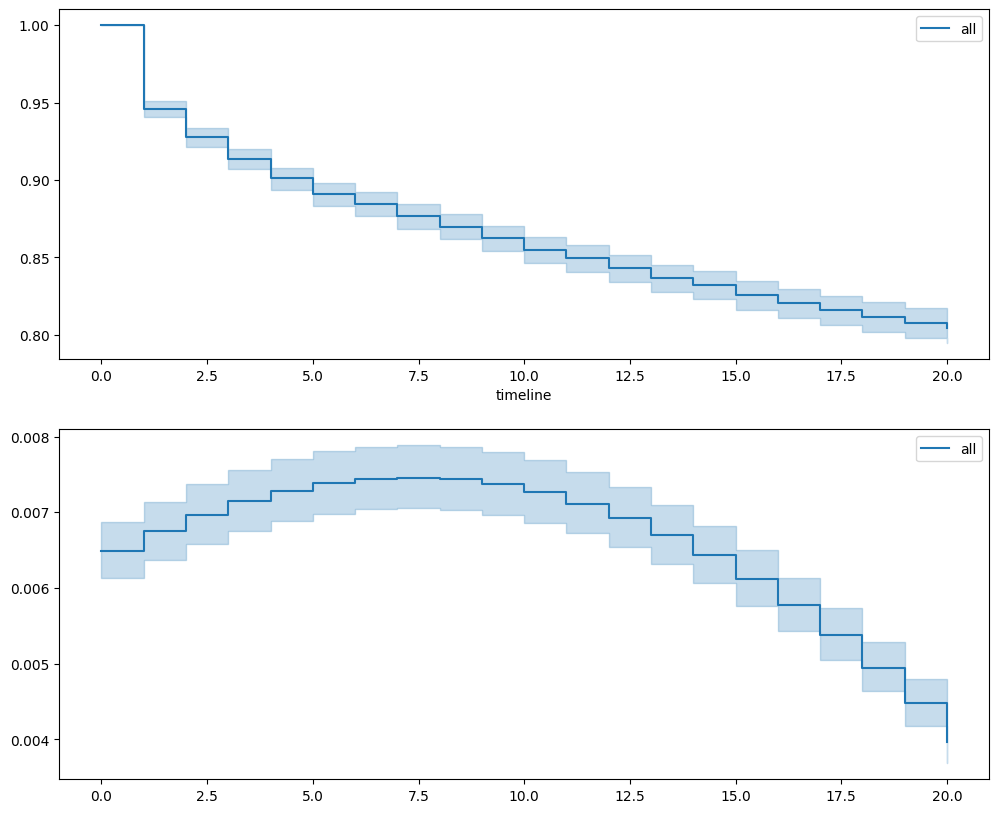

In [8]:
#only 20 months
t = np.linspace(0, 20, 21)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

# overall curve
kmf = KaplanMeierFitter()
kmf.fit(df.tenure,  # lifetime
        event_observed=df.Churn,  # end of event
        timeline=t
        )
kmf.plot_survival_function(ax=ax[0], label='all')

naf = NelsonAalenFitter()
naf.fit(df.tenure, event_observed=df.Churn, timeline=t)
naf.plot_hazard(ax=ax[1], bandwidth=20, label='all')
plt.show()

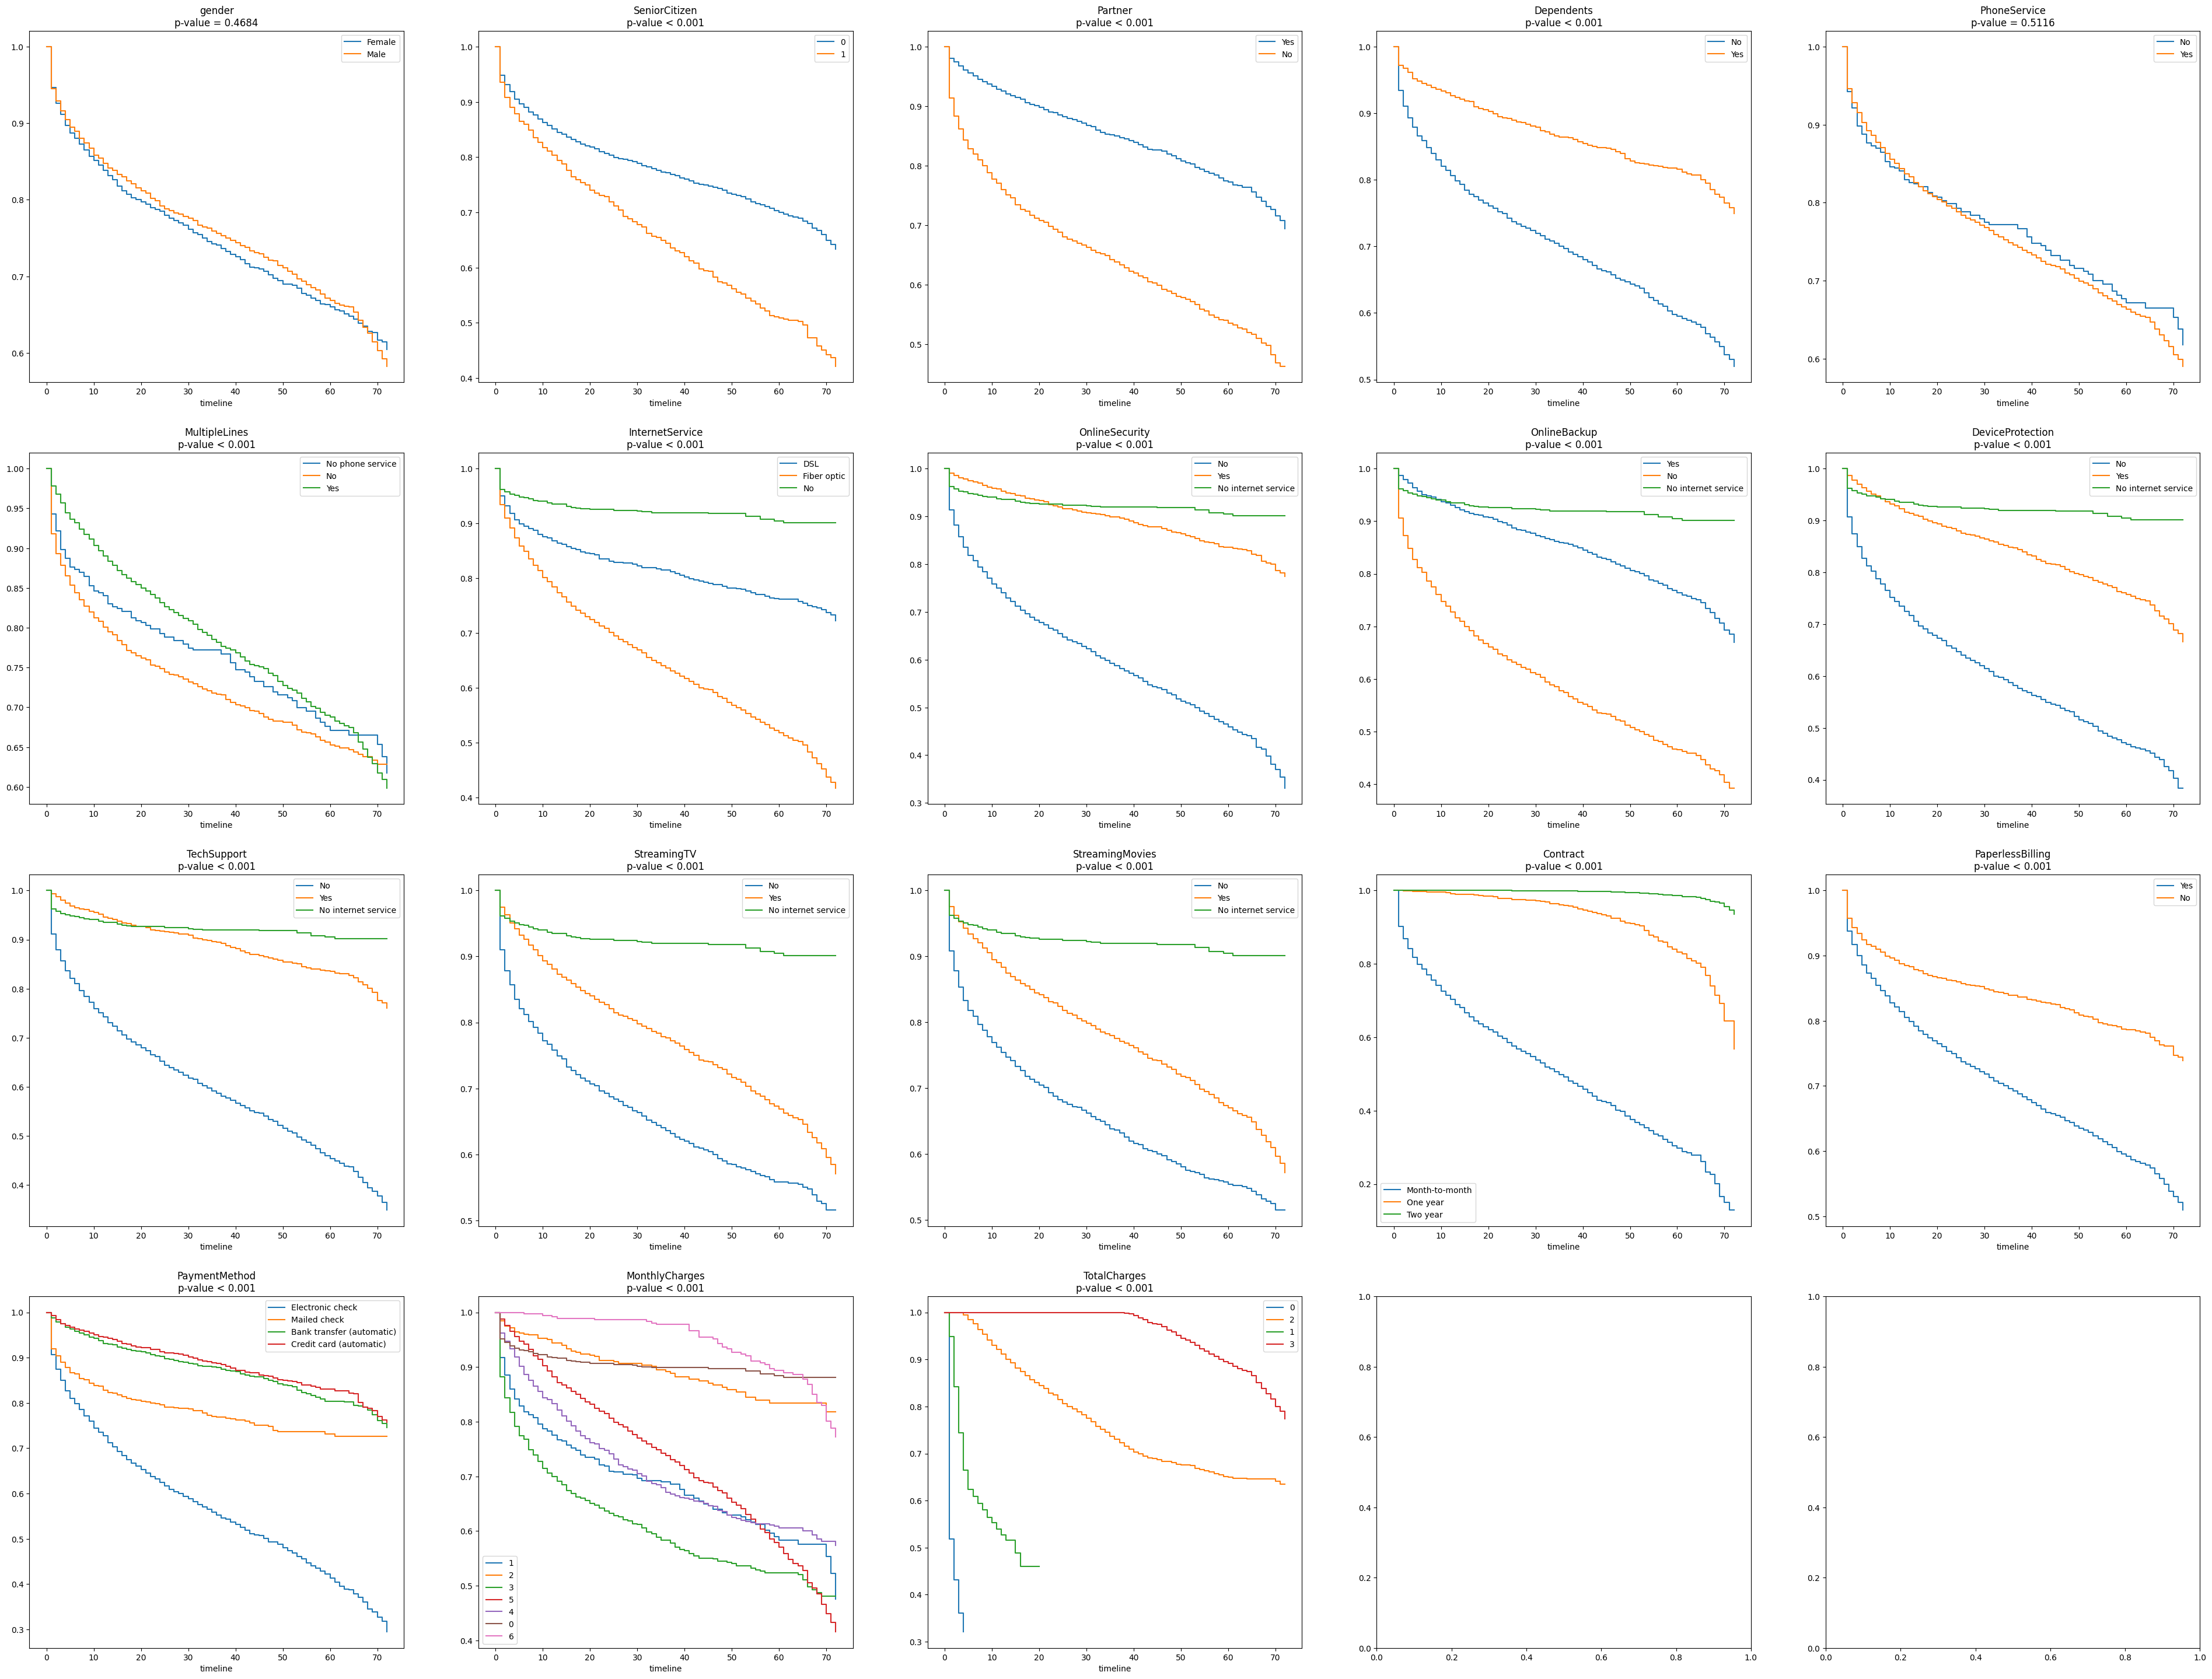

In [9]:
# bins
combiner = toad.transform.Combiner()
combiner.fit(df[['MonthlyCharges','TotalCharges']], df['Churn'], method='chi', # use chi cut bins
                min_samples=0.05)
df_t = combiner.transform(df)

#
obj_list = df_t.select_dtypes(include="object").columns[1:].to_list()
obj_list += ['MonthlyCharges','TotalCharges']

# count lines
num_plots = len(obj_list)
num_cols = math.ceil(np.sqrt(num_plots))
num_rows = math.ceil(num_plots/num_cols)
cr = [d for d in itertools.product(range(num_rows),range(num_cols))]
# surval line
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(48,36))

for ind,feature in enumerate(obj_list):
    for i in df_t[feature].unique():
        # KaplanMeier
        kmf=KaplanMeierFitter()
        df_tmp = df_t.loc[df_t[feature] == i]
        kmf.fit(df_tmp.tenure,  # life time
                event_observed=df_tmp.Churn,  # event end
                label=i)
        # pplt
        kmf.plot_survival_function(ci_show=False,
                                   ax = ax[cr[ind][0]][cr[ind][1]])
    # logrank test
    p_value = multivariate_logrank_test(event_durations = df_t.tenure,  # lifetime
                                        groups=df_t[feature],  # group
                                        event_observed=df_t.Churn  # event of time
                                       ).p_value
    p_value_text = ['p-value < 0.001' if p_value < 0.001 else 'p-value = %.4F'%p_value][0]
    ax[cr[ind][0]][cr[ind][1]].set_title("{}\n{}".format(feature, p_value_text))

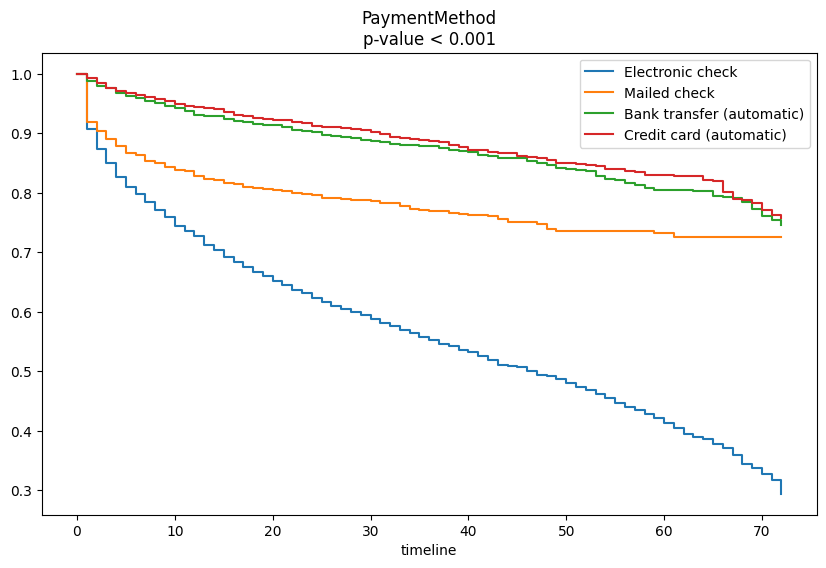

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
feature = 'PaymentMethod'
for i in df_t[feature].unique():
    # KaplanMeier
    kmf=KaplanMeierFitter()
    df_tmp = df_t.loc[df_t[feature] == i]
    kmf.fit(df_tmp.tenure,
            event_observed=df_tmp.Churn,
            label=i)

    kmf.plot_survival_function(ci_show=False,
                               ax = ax)
p_value = multivariate_logrank_test(event_durations = df_t.tenure,
                                    groups=df_t[feature],
                                    event_observed=df_t.Churn
                                   ).p_value
p_value_text = ['p-value < 0.001' if p_value < 0.001 else 'p-value = %.4F'%p_value][0]
ax.set_title("{}\n{}".format(feature, p_value_text))
plt.show()

pairwise_logrank_test(
        event_durations = df_t.tenure,
        groups=df_t.PaymentMethod,
        event_observed=df_t.Churn
)

In [11]:
for feature in obj_list:
    for i in df_t[feature].unique():
        df_tmp = df_t.loc[df_t[feature] == i]
        p_value = multivariate_logrank_test(event_durations = df_tmp.tenure,
                                            groups=df_tmp.gender,
                                            event_observed=df_tmp.Churn
                                           ).p_value
        if p_value <= 0.05:
            p_value_text = ['p-value < 0.001' if p_value < 0.001 else 'p-value = %.4F'%p_value][0]
            print('gender : {}={}, logrank test {}'.format(feature, i, p_value_text))

gender : PaymentMethod=Credit card (automatic), logrank test p-value = 0.0288
gender : MonthlyCharges=3, logrank test p-value = 0.0360
gender : MonthlyCharges=4, logrank test p-value = 0.0181


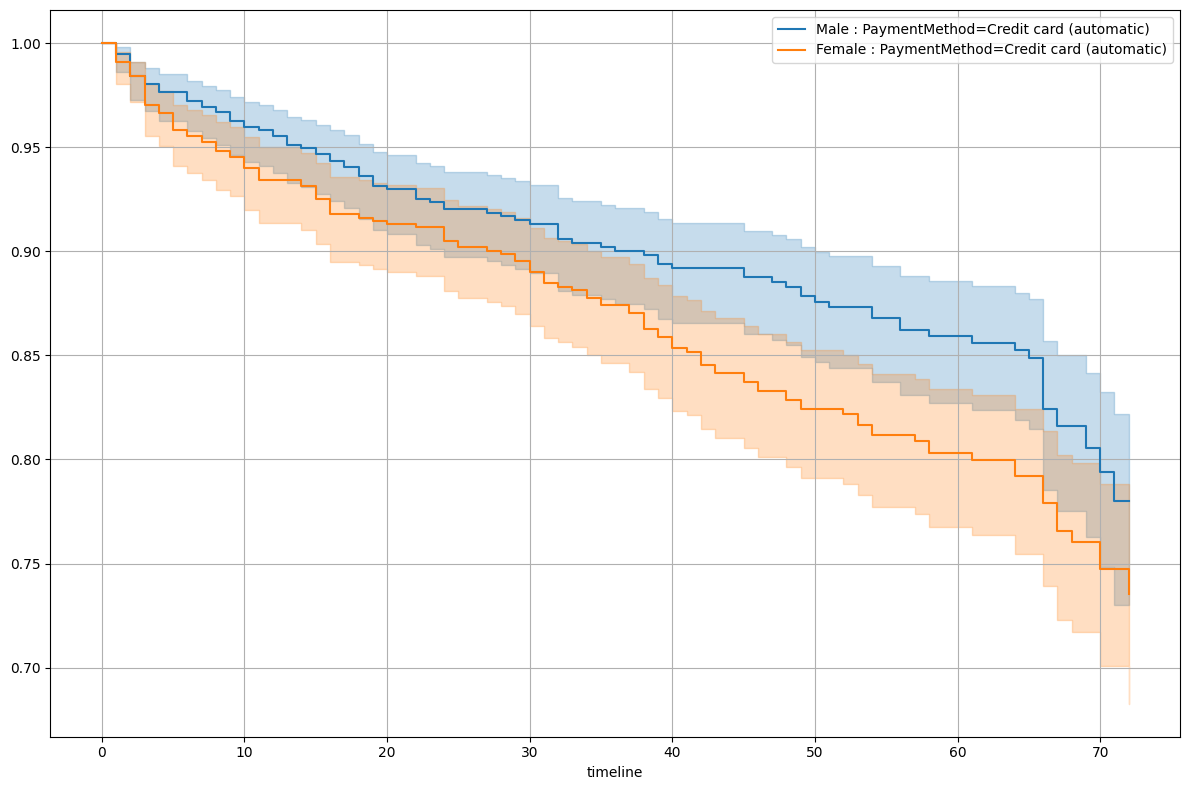

In [12]:
fig,ax = plt.subplots(figsize=(12,8))

data_male = df_t.loc[(df_t.gender=='Male') & (df_t.PaymentMethod == 'Credit card (automatic)')]
kmf_male = KaplanMeierFitter().fit(data_male.tenure,
                                   data_male.Churn,
                                   label='Male : PaymentMethod=Credit card (automatic)')
ax = kmf_male.plot_survival_function(ax=ax)

data_female = df_t.loc[(df_t.gender=='Female') & (df_t.PaymentMethod == 'Credit card (automatic)')]
kmf_female = KaplanMeierFitter().fit(data_female.tenure,
                                     data_female.Churn,
                                     label='Female : PaymentMethod=Credit card (automatic)')
ax = kmf_female.plot_survival_function(ax=ax)

plt.grid()
plt.tight_layout()

In [13]:
# feature engineering
df_model = pd.get_dummies(df.iloc[:,1:], drop_first=True)

train, test = train_test_split(df_model, test_size=0.2)

In [14]:
cph = CoxPHFitter(penalizer = 0.01)
cph.fit(train, duration_col='tenure', event_col='Churn')
cph.print_summary(decimals=1)

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4146 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1479
   partial log-likelihood = -10006.1
         time fit was run = 2024-06-06 00:42:04 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
MonthlyCharges                           0.0        1.0        0.0              0.0              0.0                  1.0                  1.0
TotalCharges                            -0.0        1.0        0.0             -0.0             -0.0                  1.0                  1.0
gender_Male                             -0.0        1.0        0.1             -0.1              0.1                  0.9                  1.1
SeniorCitizen_1                          0.0        1.0        0.1             -0.1              0.1                  0.9                  1.1
Partner_Yes                             -0.2        0.8        0.1             -0.3             -0.1                  0.7                  0.9
Dependents_Yes                          -0.1        0.9        0.1             -0.3              0.0                  0.8                  1.0
PhoneService_Yes                         0.3        1.3        0.3             -0.4              0.9                  0.7                  2.5
MultipleLines_No phone service          -0.3        0.8        0.3             -0.9              0.4                  0.4                  1.4
MultipleLines_Yes                       -0.0        1.0        0.1             -0.1              0.1                  0.9                  1.1
InternetService_Fiber optic              0.8        2.2        0.1              0.6              1.0                  1.8                  2.8
InternetService_No                      -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
OnlineSecurity_No internet service      -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
OnlineSecurity_Yes                      -0.3        0.7        0.1             -0.5             -0.2                  0.6                  0.8
OnlineBackup_No internet service        -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
OnlineBackup_Yes                        -0.2        0.8        0.1             -0.3             -0.0                  0.7                  1.0
DeviceProtection_No internet service    -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
DeviceProtection_Yes                    -0.0        1.0        0.1             -0.1              0.1                  0.9                  1.1
TechSupport_No internet service         -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
TechSupport_Yes                         -0.2        0.8        0.1             -0.4             -0.1                  0.7                  0.9
StreamingTV_No internet service         -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
StreamingTV_Yes                          0.2        1.2        0.1              0.1              0.3                  1.1                  1.4
StreamingMovies_No internet service     -0.3        0.7        0.3             -0.9              0.3                  0.4                  1.4
StreamingMovies_Yes                      0.2        1.2        0.1              0.1              0.4                  1.1                  

In [15]:
drop_col = list(cph.summary['p'][cph.summary['p'].values>0.05].index)
train_s = train.drop(drop_col, axis=1)
test_s = test.drop(drop_col, axis=1)

In [16]:
cph = CoxPHFitter(penalizer = 0.01)
cph.fit(train_s, duration_col='tenure', event_col='Churn')
cph.print_summary(decimals=1)

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4146 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1479
   partial log-likelihood = -10081.7
         time fit was run = 2024-06-06 00:42:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                    0.0        1.0        0.0              0.0              0.0                  1.0                  1.0
TotalCharges                     -0.0        1.0        0.0             -0.0             -0.0                  1.0                  1.0
Partner_Yes                      -0.3        0.7        0.1             -0.4             -0.2                  0.7                  0.8
InternetService_Fiber optic       0.5        1.7        0.1              0.3              0.7                  1.3                  2.1
OnlineSecurity_Yes               -0.3        0.8        0.1             -0.4             -0.1                  0.7                  0.9
OnlineBackup_Yes                 -0.2        0.8        0.1             -0.3             -0.1                  0.7                  0.9
TechSupport_Yes                  -0.2        0.8        0.1             -0.3             -0.0                  0.7                  1.0
StreamingTV_Yes                   0.0        1.0        0.1             -0.1              0.2                  0.9                  1.2
StreamingMovies_Yes               0.1        1.1        0.1             -0.1              0.2                  0.9                  1.2
Contract_One year                -1.3        0.3        0.1             -1.5             -1.1                  0.2                  0.3
Contract_Two year                -3.1        0.0        0.1             -3.3             -2.8                  0.0                  0.1
PaperlessBilling_Yes              0.2        1.2        0.1              0.1              0.3                  1.1                  1.4
PaymentMethod_Electronic check    0.5        1.6        0.1              0.3              0.6                  1.4                  1.8
PaymentMethod_Mailed check        0.4        1.6        0.1              0.3              0.6                  1.3                  1.8

                                 cmp to     z     p   -log2(p)
covariate                                                     
MonthlyCharges                      0.0  10.3 <0.05       79.9
TotalCharges                        0.0 -34.3 <0.05      856.1
Partner_Yes                         0.0  -5.5 <0.05       25.0
InternetService_Fiber optic         0.0   4.3 <0.05       16.1
OnlineSecurity_Yes                  0.0  -3.5 <0.05       11.2
OnlineBackup_Yes                    0.0  -2.8 <0.05        7.6
TechSupport_Yes                     0.0  -2.3 <0.05        5.5
StreamingTV_Yes                     0.0   0.6   0.5        0.9
StreamingMovies_Yes                 0.0   0.9   0.4        1.5
Contract_One year                   0.0 -13.6 <0.05      136.7
Contract_Two year                   0.0 -21.2 <0.05      329.1
PaperlessBilling_Yes                0.0   3.5 <0.05       11.1
PaymentMethod_Electronic check      0.0   7.1 <0.05       39.7
PaymentMethod_Mailed check          0.0   5.5 <0.05       25.0
---
Concordance = 0.9
Partial AIC = 20191.4
log-likelihood ratio test = 3964.0 on 14 df
-log2(p) of ll-ratio test = inf

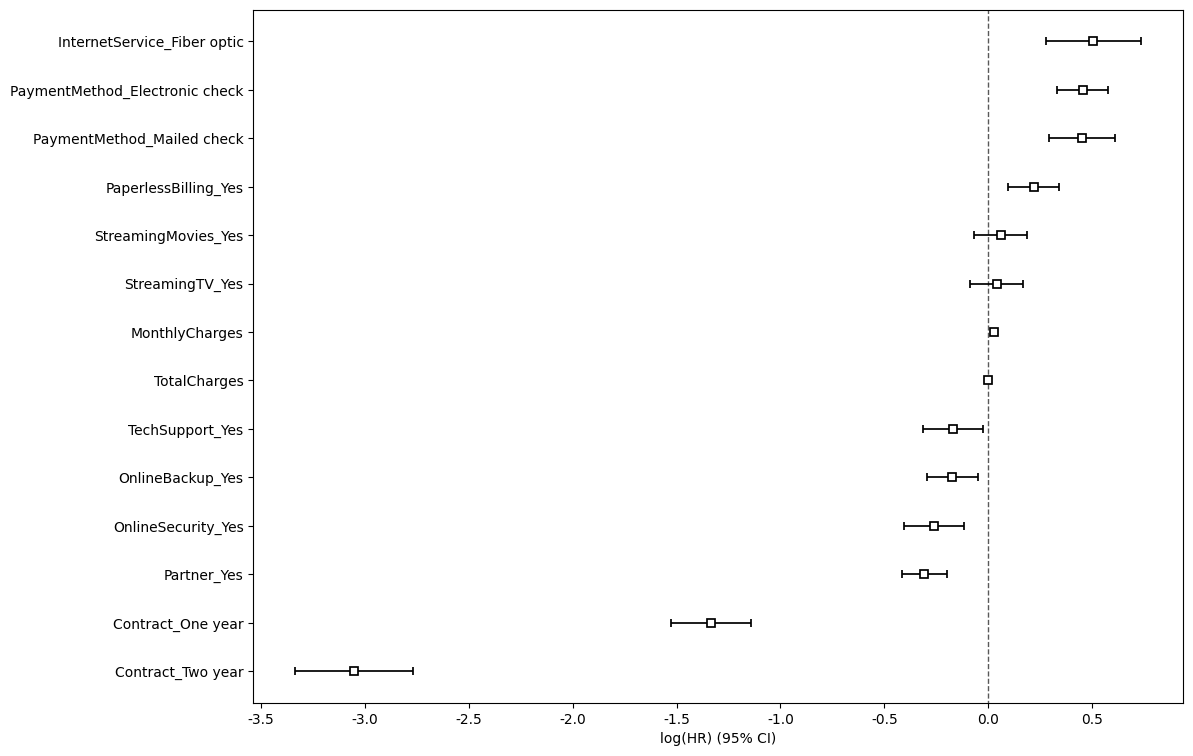

In [17]:
#feature importance
fig,ax = plt.subplots(figsize=(12,9))
cph.plot(ax=ax)
plt.show()

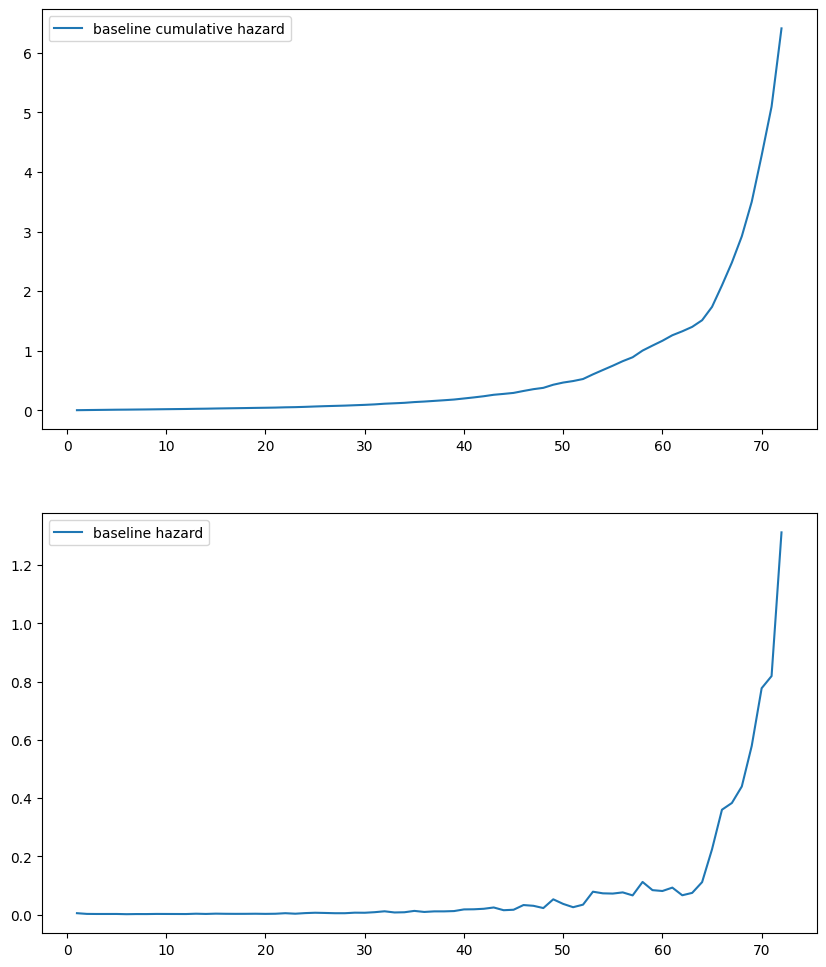

In [18]:
#risk analysis

fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
cph.baseline_cumulative_hazard_.plot(ax=ax[0])

cph.baseline_hazard_.plot(ax=ax[1])
plt.show()

ICI =  0.028077036323719697
E50 =  0.004527097937899738


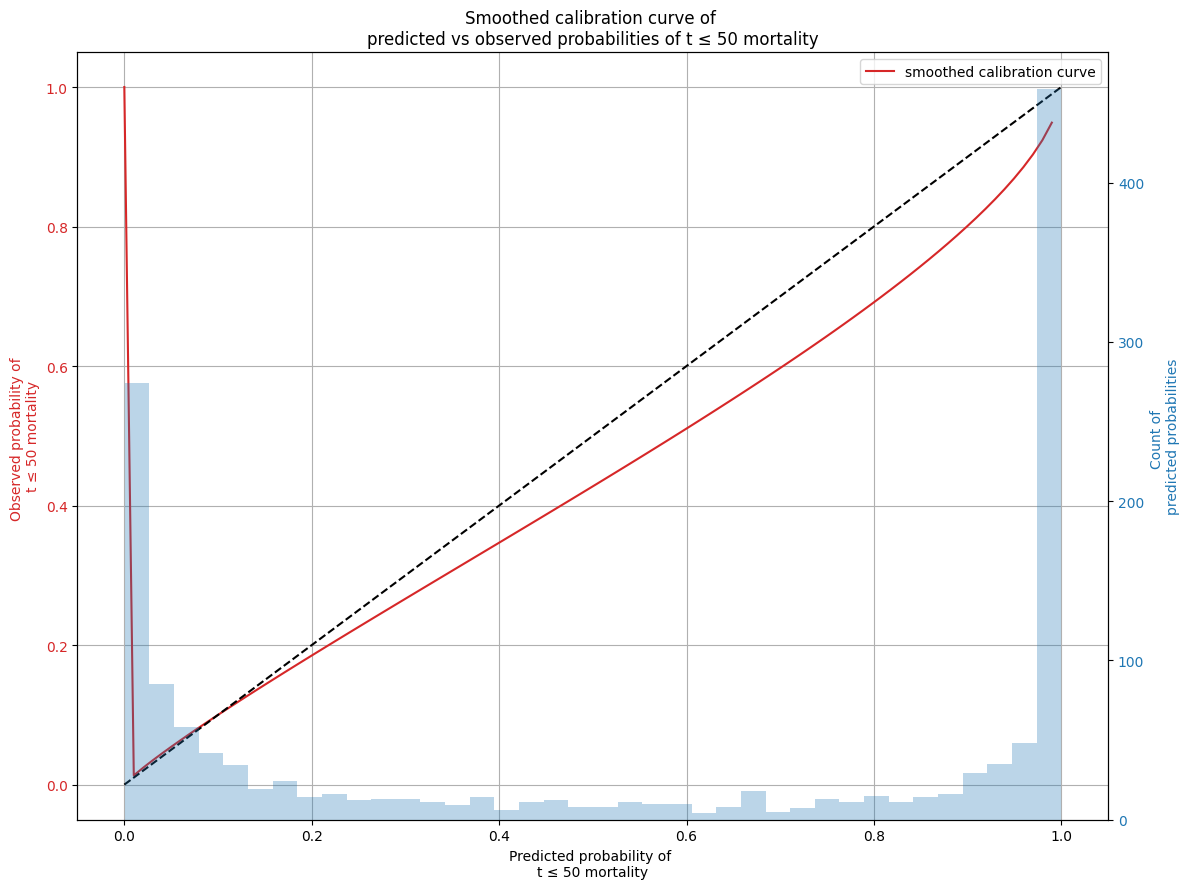

In [19]:
#evaluation
fig,ax = plt.subplots(figsize=(12,9))
survival_probability_calibration(cph, test_s, t0=50, ax=ax)
ax.grid()

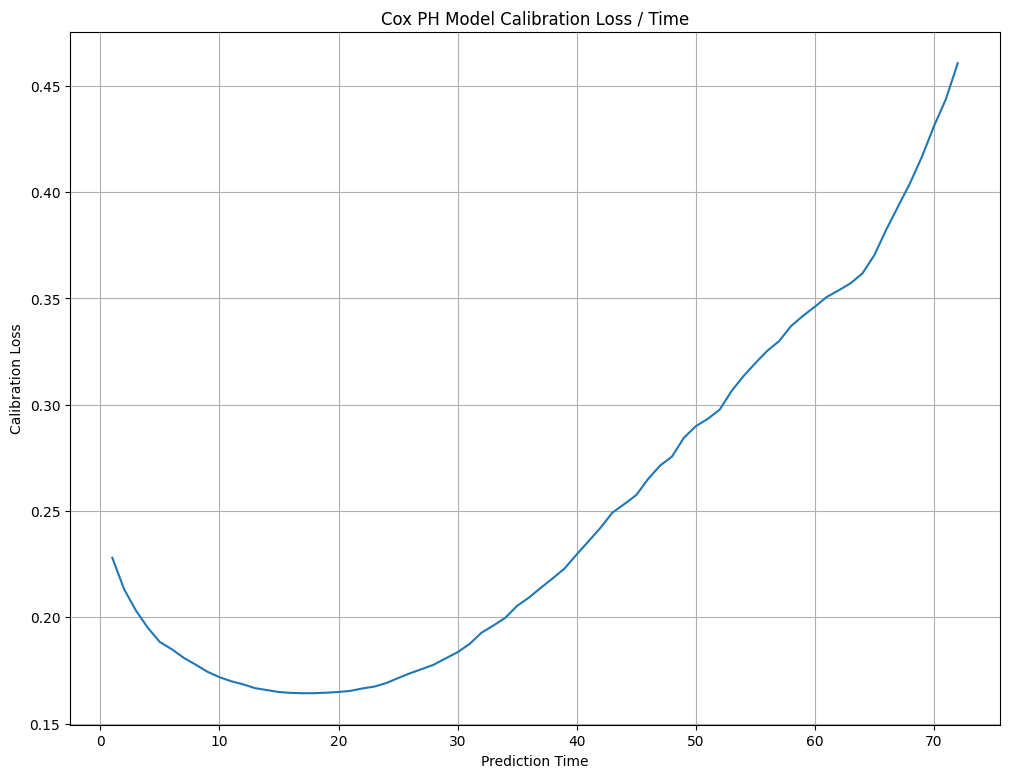

In [20]:
loss_dict = {}
for i in range(1,73):
    score = brier_score_loss(
        test_s.Churn,
        1 - np.array(cph.predict_survival_function(test_s).loc[i]),
        pos_label=1 )
    loss_dict[i] = [score]

loss_df = pd.DataFrame(loss_dict).T

fig, ax = plt.subplots(figsize=(12,9))
ax.plot(loss_df.index, loss_df)
ax.set(xlabel='Prediction Time', ylabel='Calibration Loss', title='Cox PH Model Calibration Loss / Time')
ax.grid()

In [ ]:
# predict the value of the rest

In [21]:

churn0 = df_model.query("Churn == 0")
churn0_median_survive = cph.predict_median(churn0).rename('median_survive')

values = pd.concat([churn0_median_survive, churn0[['MonthlyCharges','tenure']]], axis=1)
values['RemainTenure'] = values['median_survive'] - values['tenure']
values['RemainingValue'] = values['MonthlyCharges'] * values['RemainTenure']


inf_rate = values[values['RemainingValue']==float('inf')].shape[0]/values.shape[0]
neg_rate = values[values['RemainingValue']<0].shape[0]/values.shape[0]
print('{:*^60}'.format('inf_rate&neg_rate:'), '\n', 'inf_rate=%.2f' % inf_rate, 'neg_rate=%.2f' % neg_rate)
values.tail()

*********************inf_rate&neg_rate:********************* 
 inf_rate=0.33 neg_rate=0.04


,median_survive,MonthlyCharges,tenure,RemainTenure,RemainingValue
7037,inf,21.15,72,inf,inf
7038,53.0,84.80,24,29.0,2459.2
7039,inf,103.20,72,inf,inf
7040,33.0,29.60,11,22.0,651.2
7042,inf,105.65,66,inf,inf


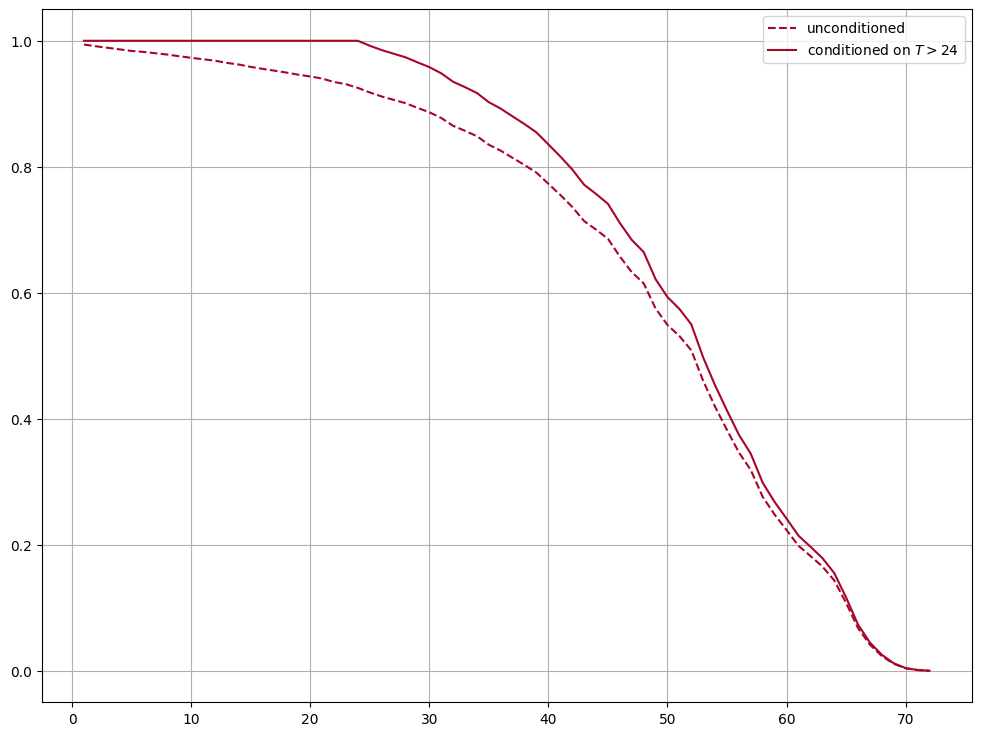

In [22]:
unconditioned_sf = cph.predict_survival_function(churn0)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'tenure']]).clip(upper=1))

fig, ax = plt.subplots(figsize=(12,9))
subject = 7038
tenures = df_model['tenure'].loc[subject,]
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>{:.0f}$".format(tenures))
ax.legend()
ax.grid()


In [23]:
# reduce bias
churn0_median_survive_new = median_survival_times(conditioned_sf)
values_new = pd.concat([churn0[['tenure','MonthlyCharges']], churn0_median_survive_new.T], axis=1)
values_new.rename(columns={0.5:'median_survive'}, inplace=True)
values_new['RemainTenure'] = values_new['median_survive'] - values_new['tenure']
values_new['RemainingValue'] = values_new['MonthlyCharges'] * values_new['RemainTenure']
# RemainingValue
inf_rate = values_new[values_new['RemainingValue']==float('inf')].shape[0]/values_new.shape[0]
neg_rate = values_new[values_new['RemainingValue']<0].shape[0]/values_new.shape[0]
print('{:*^60}'.format('inf_rate&neg_rate:'), '\n', 'inf_rate=%.2f' % inf_rate, 'neg_rate=%.2f' % neg_rate)
values_new.tail()

*********************inf_rate&neg_rate:********************* 
 inf_rate=0.34 neg_rate=0.00


,tenure,MonthlyCharges,median_survive,RemainTenure,RemainingValue
7037,72,21.15,inf,inf,inf
7038,24,84.80,53.0,29.0,2459.2
7039,72,103.20,inf,inf,inf
7040,11,29.60,36.0,25.0,740.0
7042,66,105.65,inf,inf,inf


In [ ]:
# lift remaining value

In [24]:
def predict_median_func(churn0):
    unconditioned_sf = cph.predict_survival_function(churn0)
    conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'tenure']]).clip(upper=1))
    churn0_median_survive_new = median_survival_times(conditioned_sf).T
    return churn0_median_survive_new

tmp =df_model.loc[values_new.index,].copy()
tmp['Contract_One year'] = tmp.apply(lambda x: 1 if x['Contract_Two year'] == 0 else 0, axis=1)
values_new['contract_1y_tenure_pred'] = predict_median_func(tmp)
tmp =df_model.loc[values_new.index,].copy()
tmp['Contract_Two year'] = 1
tmp['Contract_One year'] = 0
values_new['contract_2y_tenure_pred'] = predict_median_func(tmp)


tmp =df_model.loc[values_new.index,].copy()
tmp['OnlineSecurity_Yes'] = 1
values_new['OnlineSecurity_tenure_pred'] = predict_median_func(tmp)


values_new['Contract_1y Diff'] = (values_new['contract_1y_tenure_pred'] - values_new['median_survive']) * values_new['MonthlyCharges']
values_new['Contract_2y Diff'] = (values_new['contract_2y_tenure_pred'] - values_new['median_survive']) * values_new['MonthlyCharges']
values_new['OnlineSecurity Diff'] = (values_new['OnlineSecurity_tenure_pred'] - values_new['median_survive']) * values_new['MonthlyCharges']


values_new.head().T

,0,1,3,6,7
tenure,1.00,34.00,45.0,22.0,10.00
MonthlyCharges,29.85,56.95,42.3,89.1,29.75
median_survive,29.00,59.00,68.0,34.0,34.00
RemainTenure,28.00,25.00,23.0,12.0,24.00
RemainingValue,835.80,1423.75,972.9,1069.2,714.00
contract_1y_tenure_pred,46.00,59.00,68.0,46.0,49.00
contract_2y_tenure_pred,65.00,72.00,inf,65.0,67.00
OnlineSecurity_tenure_pred,32.00,59.00,68.0,36.0,34.00
Contract_1y Diff,507.45,0.00,0.0,1069.2,446.25
Contract_2y Diff,1074.60,740.35,inf,2762.1,981.75


In [25]:
df.loc[0,]


customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                              0
Name: 0, dtype: object